In [1]:
import os
import matplotlib.pyplot as plt
import torch
import h5py
import random

In [2]:
# TODO: 
# Edit it accordingly to your needs 

WORK_DIR = './'
DOWNLOAD_URL = 'https://figshare.com/ndownloader/articles/1512427/versions/5'
ZIP_FILE = './BrainCancer.zip'
DATA_DIR = './data/'
EXTRACT_DIR = './data/BrainCancerRawData/'
DOTMAT_DIR = DATA_DIR + 'BrainCancerDotMat/'
DATASET_FILE = DATA_DIR + 'BrainCancerDataset.pt'

In [3]:
# check if the data is already downloaded, if not download it
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(ZIP_FILE):
    os.system('wget -O %s %s' % (ZIP_FILE, DOWNLOAD_URL))
else:
    print('Data already downloaded...\nSkipping download')

[0] Downloading 'https://figshare.com/ndownloader/articles/1512427/versions/5' ...
Saving './BrainCancer.zip'
HTTP response 200  [https://figshare.com/ndownloader/articles/1512427/versions/5]


In [4]:
# check if the data is already extracted, if not extract it
if not os.path.exists(EXTRACT_DIR):
    os.system('unzip %s -d %s' % (ZIP_FILE, EXTRACT_DIR))
    # The dataset was split in more .zips files due to the dimension
    to_unzip = []
    # search for all the .zip files in DATA_DIR
    for root, dirs, files in os.walk(EXTRACT_DIR):
        for file in files:
            if file.endswith('.zip'):
                to_unzip.append(os.path.join(EXTRACT_DIR, file))
    print(f"The data were split in {len(to_unzip)} .zip files\n Starting to unzip...")
    # extract it in the DOTMAT_DIR
    os.makedirs(DOTMAT_DIR, exist_ok=True)
    for zip_file in to_unzip:
        print(f"Extracting {zip_file} ...")
        os.system(f'unzip -q {zip_file} -d {DOTMAT_DIR}')
else:
    print('Data already extracted...\nSkipping extraction')
    
print("In total we have ", len(os.listdir(DOTMAT_DIR)), " .mat files!\nStarting to read it ...")

Archive:  ./BrainCancer.zip
 extracting: ./data/BrainCancerRawData/brainTumorDataPublic_1-766.zip  
 extracting: ./data/BrainCancerRawData/brainTumorDataPublic_1533-2298.zip  
 extracting: ./data/BrainCancerRawData/brainTumorDataPublic_767-1532.zip  
 extracting: ./data/BrainCancerRawData/brainTumorDataPublic_2299-3064.zip  
 extracting: ./data/BrainCancerRawData/cvind.mat  
 extracting: ./data/BrainCancerRawData/README.txt  
The data were split in 4 .zip files
 Starting to unzip...
Extracting ./data/BrainCancerRawData/brainTumorDataPublic_1-766.zip ...
Extracting ./data/BrainCancerRawData/brainTumorDataPublic_1533-2298.zip ...
Extracting ./data/BrainCancerRawData/brainTumorDataPublic_767-1532.zip ...
Extracting ./data/BrainCancerRawData/brainTumorDataPublic_2299-3064.zip ...
In total we have  3064  .mat files!
Starting to read it ...


In [5]:
# read the .mat files
matfile_names = []
images= []
labels = []

for root, dirs, files in os.walk(DOTMAT_DIR):
    for file in files:
        if file.endswith('.mat'):
            matfile_names.append(os.path.join(DOTMAT_DIR, file))

for matfile in matfile_names:
    with h5py.File(matfile, 'r') as f:
        image = torch.tensor(f['cjdata/image'][:])
        label = torch.tensor(f['cjdata/label'][:])
        # The labels in the dataset are 1-indexed, so we need to subtract 1
        label -= 1
        images.append(image)
        labels.append(label)
print("done!")

done!


In [6]:
class Dataset(torch.utils.data.Dataset):
    """
    Class overloading the torch.utils.data.Dataset class to 
    create a custom dataset object
    """

    def __init__ (self, x, y):
        self.x = x
        self.y = y
        # type casting to avoid errors and warnings with the network
        self.x = self.x.float()
        self.y = self.y.long()

    def __len__ (self): 
        return(len(self.y))

    def __getitem__ (self, idx):
        return self.x[idx], self.y[idx]

In [7]:
count_512 = 0
count_256 = 0
for i in range(len(images)):
    if images[i][0].shape[0] == 512:
        count_512 += 1
    elif images[i][0].shape[0] == 256:
        count_256 += 1
    else:
        print("Index: ", i, " Shape: ", images[i][0].shape)
print("Images with shape 512x512: ", count_512)
print("Images with shape 256x256: ", count_256)
print("Total images: ", len(images))
print("Dropping the images with shape 256x256 ...")

# there are 12 images (over 3k +) with shape 256x256...
# Just drop it 
index_to_drop = [i for i in range(len(images)) if images[i].shape[0] == 256]

images = [images[i] for i in range(len(images)) if i not in index_to_drop]
labels = [labels[i] for i in range(len(labels)) if i not in index_to_drop]

# cast to tensor
images = torch.stack(images)
labels = torch.stack(labels)

print("Generating the dataset ...")
# create the dataset
dataset = Dataset(images, labels)

Images with shape 512x512:  3049
Images with shape 256x256:  15
Total images:  3064
Dropping the images with shape 256x256 ...
Generating the dataset ...


In [8]:
# save the dataset
torch.save(dataset, DATASET_FILE)

Visualize some data: 

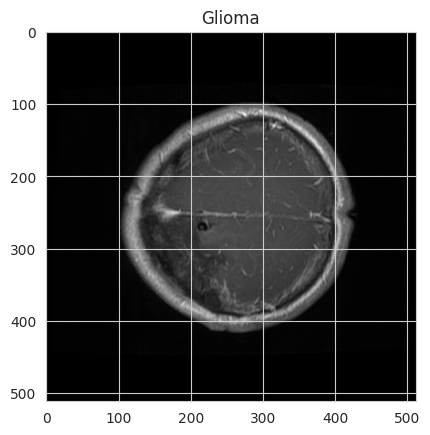

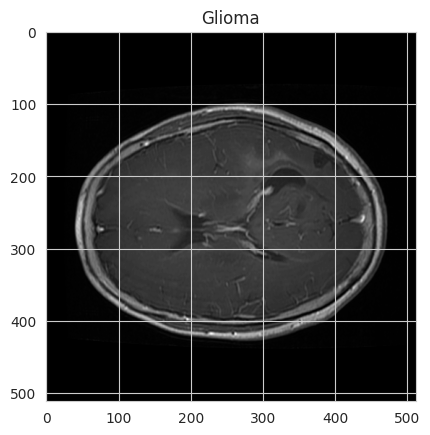

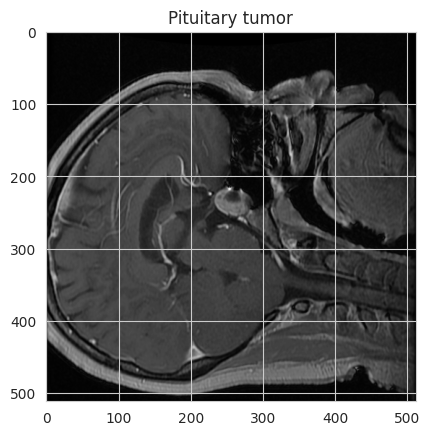

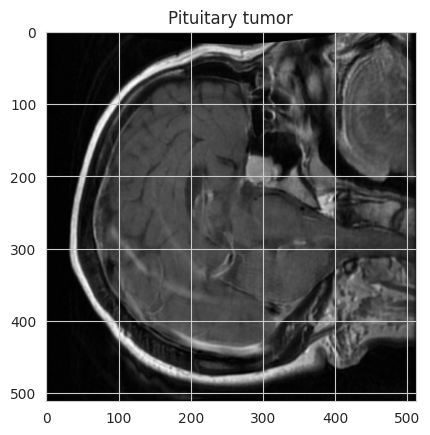

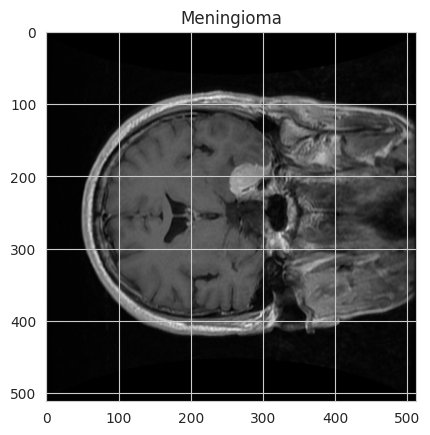

In [9]:
# visualize some data
n = 5
rnd_idx = random.sample(range(len(dataset)), n)

def translate_label(label):
    if label == 0:
        return "Meningioma"
    elif label == 1:
        return "Glioma"
    elif label == 2:
        return "Pituitary tumor"
    else:
        return "unknown"

for i in rnd_idx:
    img, label = dataset[i]
    plt.imshow(img, cmap='gray')
    plt.title(f"{translate_label(label.item())}")
    plt.show()